# **1.BAGGING**


Bagging = Bootstrapping + aggregation


- Bootstrapping (Lấy mẫu có lặp lại): Tạo ra nhiều tập con dữ liệu khác nhau từ tập huấn luyện gốc bằng cách lấy mẫu ngẫu nhiên có hoàn lại (một mẫu có thể xuất hiện nhiều lần). Số lượng mẫu bằng số lượng mẫu trong tập gốc.
- Aggregation (Tổng  hợp kết quả): Kết hợp kết quả dự đoán của tất cả các mô hình. Đối với bài toán phân loại (như CIFAR-100), kết quả cuối cùng thường dựa trên đa số phiếu bầu (Majority Voting)

Huấn luyện các mô hình cơ sở (base learners) một cách độc lập trên từng tập con dữ liệu đã tạo.

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import time
import joblib  
from sklearn.decomposition import PCA

## Load dataset

In [2]:
PATH = r'..\datasets'

trainset = torchvision.datasets.CIFAR100(root=PATH, train=True, download=False)
testset = torchvision.datasets.CIFAR100(root=PATH, train=False, download=False)
    
print(f"Train images: {len(trainset)}")
print(f"Test images: {len(testset)}")

Train images: 50000
Test images: 10000


## Data Preprocessing and Flattening

Vì các mô hình Machine Learning truyền thống trong sklearn không xử lý trực tiếp ảnh 4 chiều, chúng ta cần chuyển đổi ảnh về dạng vector 1 chiều.

In [ ]:
# full dataset
n_train_samples = 50000 
n_test_samples = 10000

# Chuyển đổi sang kiểu float để chuẩn hóa
x_train_flat = trainset.data[:n_train_samples].reshape(n_train_samples, -1).astype(np.float32)
y_train = np.array(trainset.targets[:n_train_samples])

x_test_flat = testset.data[:n_test_samples].reshape(n_test_samples, -1).astype(np.float32)
y_test = np.array(testset.targets[:n_test_samples])

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

print(f"Training data shape: {x_train_scaled.shape}")
print(f"Testing data shape: {x_test_scaled.shape}")
print("Data preprocessing: Success")

Training data shape: (5000, 3072)
Testing data shape: (1000, 3072)
Data preprocessing: Success


## **1.1 Random Forest Classifier**

Random Forest là một dạng đặc biệt của Bagging, sử dụng nhiều cây quyết định (Decision Trees) làm mô hình cơ sở.

In [14]:
# Khởi tạo Random Forest
# n_estimators: Số lượng cây (mô hình cơ sở)
# n_jobs=-1: Sử dụng tất cả các nhân CPU để chạy song song
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Huấn luyện mô hình
print("Training Random Forest...")
rf_clf.fit(x_train_scaled, y_train)

y_pred_rf = rf_clf.predict(x_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest - Test Accuracy: {accuracy_rf:.4f}")

Training Random Forest...
Random Forest - Test Accuracy: 0.1360


Thời gian chạy quá lâu!!

Tăng số lượng mẫu sử dụng 50k thay vì 5k như trên và sử dụng PCA (200 thành phần) vad 200 cây

In [ ]:
# Giảm chiều dữ liệu với PCA (3072 -> 200 components)
start_pca = time.time()
pca = PCA(n_components=200, svd_solver='randomized', random_state=42)
x_train_pca = pca.fit_transform(x_train_full)
x_test_pca = pca.transform(x_test_full)
print(f"PCA completed in: {time.time() - start_pca:.2f}s")

# Huấn luyện Random Forest (100 estimators)
start_rf = time.time()
rf_optimized = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      random_state=42, 
                                      verbose=1)
rf_optimized.fit(x_train_pca, y_train_full)
print(f"RF Training completed in: {(time.time() - start_rf)/60:.2f} minutes")

# Lưu mô hình và PCA
joblib.dump(pca, 'pca_cifar100_v1.joblib')
# Lưu Random Forest
joblib.dump(rf_optimized, 'rf_cifar100_v1.joblib')

print("Models saved successfully: 'pca_cifar100_v1.joblib' & 'rf_cifar100_v1.joblib'")

# Đánh giá nhanh
y_pred = rf_optimized.predict(x_test_pca)
print(f"\nFinal Accuracy: {accuracy_score(y_test_full, y_pred)*100:.2f}%")

PCA completed in: 16.47s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min


## **1.2 Bagging Classifier with SVM**

kết quả dưới là dữ liệu cũ 5k ảnh, chưa train 50k

In [ ]:
# Khởi tạo mô hình cơ sở (Base Learner) là SVM
base_svc = SVC(kernel='rbf', C=1.0, random_state=42)

# Cấu hình Bagging cho SVM
bagging_svc = BaggingClassifier(estimator=base_svc, 
                                 n_estimators=10, 
                                 max_samples=0.5, # Mỗi mô hình học trên 50% dữ liệu (Bootstrapping)
                                 n_jobs=-1, 
                                 random_state=42)

# Huấn luyện (Training)
print("Training Bagging SVM ...")
bagging_svc.fit(x_train_scaled, y_train)
# Lưu model
joblib.dump(bagging_svc, 'bagging_svc_cifar100_v1.joblib')

#  Đánh giá (Aggregating)
y_pred_bag = bagging_svc.predict(x_test_scaled)
accuracy_bag = accuracy_score(y_test, y_pred_bag)

print(f"Bagging SVM - Test Accuracy: {accuracy_bag:.4f}")

Training Bagging SVM ...
Bagging SVM - Test Accuracy: 0.1420


## Visualize Prediction Results

Chúng ta sẽ hiển thị một lưới ảnh kèm theo nhãn thực tế (True) và nhãn dự đoán (Pred). Nếu dự đoán sai, nhãn sẽ hiển thị màu đỏ.

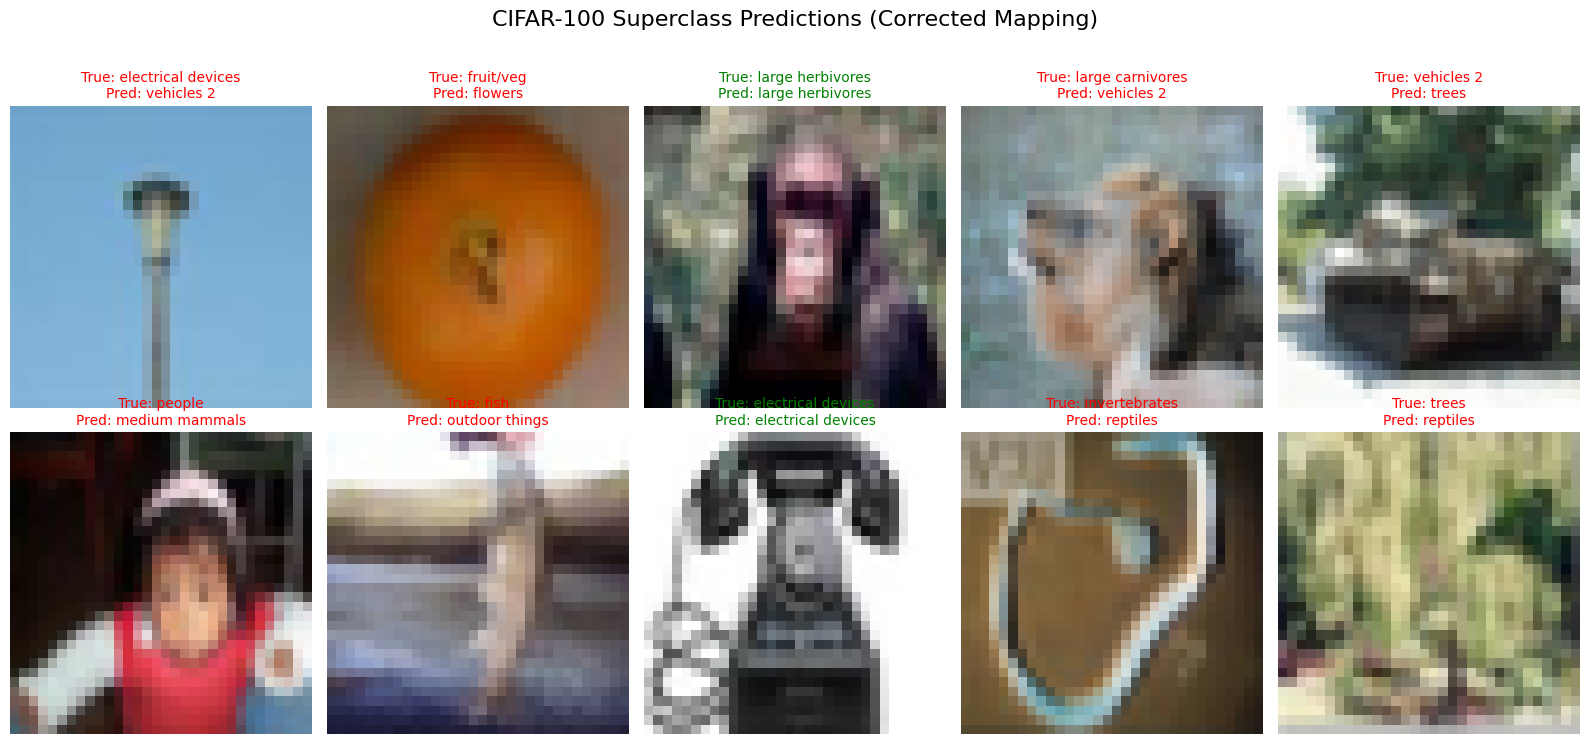

Visualization: Completed successfully


In [21]:

superclass_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit/veg',
    'electrical devices', 'furniture', 'insects', 'large carnivores', 'outdoor things',
    'outdoor scenes', 'large herbivores', 'medium mammals', 'invertebrates', 'people',
    'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

fine_to_coarse_map = [4, 1, 14, 8, 0, 6, 7, 7, 18, 3, 3, 14, 9, 18, 7, 11, 3, 9, 7, 11, 6, 11, 5, 10, 7, 6, 13, 15, 3, 15, 0, 11, 1, 10, 12, 14, 16, 9, 11, 5, 5, 19, 8, 8, 15, 13, 14, 17, 18, 10, 16, 4, 17, 4, 2, 0, 17, 4, 18, 17, 10, 3, 2, 12, 12, 16, 12, 1, 9, 19, 2, 10, 0, 1, 16, 12, 9, 13, 15, 13, 16, 19, 2, 4, 6, 19, 5, 5, 8, 19, 18, 1, 2, 15, 6, 0, 17, 8, 14, 13]

# Chọn ngẫu nhiên 10 mẫu
n_test_available = len(y_pred_rf)
random_indices = np.random.choice(n_test_available, 10, replace=False)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(random_indices):
    # Lấy ảnh gốc từ testset
    img = testset.data[idx]
    
    # Lấy nhãn gốc (Fine Label 0-99)
    actual_fine = testset.targets[idx]
    predicted_fine = y_pred_rf[idx]
    
    # Ánh xạ sang siêu lớp (Coarse Label 0-19)
    actual_coarse = fine_to_coarse_map[actual_fine]
    predicted_coarse = fine_to_coarse_map[predicted_fine]
    
    # Kiểm tra đúng/sai dựa trên siêu lớp
    is_correct = (actual_coarse == predicted_coarse)
    color = 'green' if is_correct else 'red'
    
    # Hiển thị
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {superclass_names[actual_coarse]}\nPred: {superclass_names[predicted_coarse]}", 
              color=color, fontsize=10)
    plt.axis('off')

plt.suptitle("CIFAR-100 Superclass Predictions (Corrected Mapping)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Visualization: Completed successfully")

## Evaluation Metrics

Detailed Classification Report (First 10 Superclasses):
                    precision    recall  f1-score   support

   aquatic mammals       0.15      0.17      0.16        12
              fish       0.00      0.00      0.00        11
           flowers       0.00      0.00      0.00        12
   food containers       0.00      0.00      0.00         7
         fruit/veg       0.00      0.00      0.00         8
electrical devices       0.00      0.00      0.00         4
         furniture       0.43      0.20      0.27        15
           insects       0.12      0.23      0.16        13
  large carnivores       0.20      0.08      0.12        12
    outdoor things       0.00      0.00      0.00        10
    outdoor scenes       0.00      0.00      0.00        16
  large herbivores       0.12      0.09      0.11        11
    medium mammals       0.10      0.10      0.10        10
     invertebrates       0.00      0.00      0.00         6
            people       0.00      0.00    

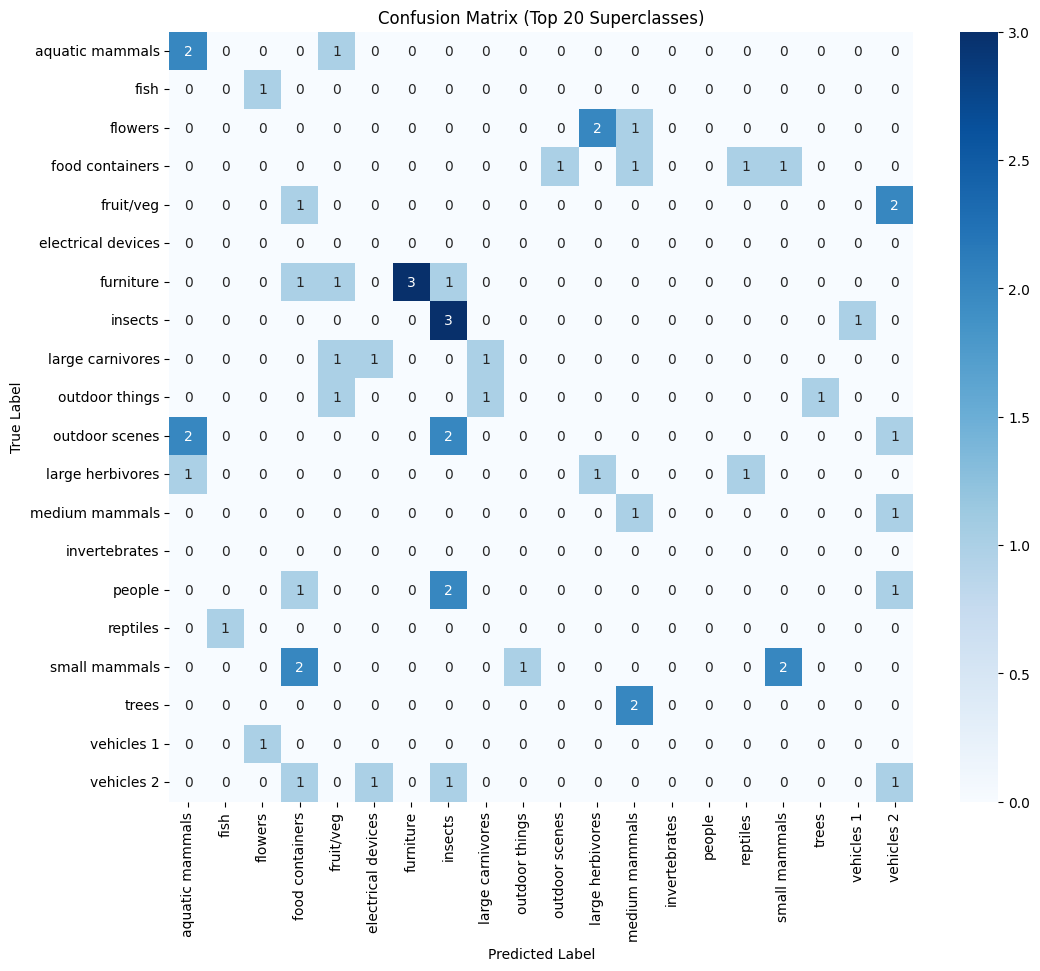

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# In báo cáo chi tiết cho 10 siêu lớp đầu tiên 
print("Detailed Classification Report (First 10 Superclasses):")
print(classification_report(y_test, y_pred_rf, target_names=superclass_names[:20], labels=range(20)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 10))
sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues', 
            xticklabels=superclass_names[:20], yticklabels=superclass_names[:20])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Top 20 Superclasses)')
plt.show()

## Bias-Variance Error Analysis

In [23]:
# Tính độ chính xác trên tập Train để so sánh
y_pred_train_rf = rf_clf.predict(x_train_scaled)
train_accuracy = accuracy_score(y_train, y_pred_train_rf)
test_accuracy = accuracy_rf

#  Phân tích lỗi
# Lỗi cao trên Train = High Bias (Mô hình chưa đủ mạnh)
# Lỗi Train thấp nhưng Test cao = High Variance (Overfitting)
print(f"Analysis Results:")
print(f"  - Training Error: {1 - train_accuracy:.4f} (Indicates Bias)")
print(f"  - Testing Error:  {1 - test_accuracy:.4f}")
print(f"  - Generalization Gap: {test_accuracy - train_accuracy:.4f} (Indicates Variance)")

if (1 - train_accuracy) > 0.2:
    print("Conclusion: High Bias. The model is too simple for CIFAR-100.")
elif (train_accuracy - test_accuracy) > 0.1:
    print("Conclusion: High Variance. Bagging is helping, but more samples/regularization needed.")
else:
    print("Conclusion: Balanced, but overall performance might be limited by 'Irreducible Error'.")

Analysis Results:
  - Training Error: 0.0000 (Indicates Bias)
  - Testing Error:  0.8640
  - Generalization Gap: -0.8640 (Indicates Variance)
Conclusion: High Variance. Bagging is helping, but more samples/regularization needed.


 Với các thuật toán Machine Learning truyền thống (như Random Forest hay SVM), lỗi lớn nhất thường nằm ở Bias. Do đặc trưng pixel của ảnh $32 \times 32$ quá phức tạp, các mô hình này "không đủ sức" để học hết các đường biên phân loại, dẫn đến Bias cao. Đó là lý do chúng ta phải chuyển sang CNN.

# **2. BOOSTING**

Khác với Bagging huấn luyện các mô hình độc lập, Boosting là một thuật toán học tuần tự (sequential). Nó cố gắng biến các "mô hình yếu" (weak learners) thành "mô hình mạnh" bằng cách tập trung vào những mẫu dữ liệu mà các mô hình trước đó đã làm sai. Mục tiêu chính của Boosting là giảm Bias (Độ chệch).

Các bước trong thuật toán Boosting
- Gán trọng số ban đầu: Mọi mẫu dữ liệu được gán trọng số bằng nhau.

- Huấn luyện tuần tự:

    + Huấn luyện một mô hình yếu trên dữ liệu.
    + Tính toán sai số.
    + Cập nhật trọng số: Tăng trọng số cho những mẫu bị đoán sai để mô hình sau tập trung học những mẫu này kỹ hơn.

- Kết hợp: Các mô hình được tổng hợp lại theo trọng số dựa trên độ chính xác của chúng.

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## **2.1 AdaBoost Classifier**

AdaBoost (Adaptive Boosting) thường sử dụng các cây quyết định cụt (Decision Stumps - cây chỉ có 1 tầng) làm mô hình cơ sở.

In [ ]:
# Khởi tạo mô hình Weak Learner
# DecisionTreeClassifier với max_depth=1 được gọi là Decision Stump
weak_learner = DecisionTreeClassifier(max_depth=1)

# Thiết lập AdaBoost
# n_estimators: Số lượng mô hình học tuần tự
# learning_rate: Tốc độ học
ada_clf = AdaBoostClassifier(estimator=weak_learner, 
                             n_estimators=50, 
                             learning_rate=1.0, 
                             random_state=42)

# Huấn luyện mô hình
print("Training AdaBoost Classifier...")
ada_clf.fit(x_train_scaled, y_train)
# Lưu model
joblib.dump(ada_clf, 'ada_clf_cifar100_v1.joblib')

# Dự đoán và đánh giá
y_pred_ada = ada_clf.predict(x_test_scaled)
accuracy_ada = accuracy_score(y_test, y_pred_ada)

print(f"AdaBoost - Test Accuracy: {accuracy_ada:.4f}")

Training AdaBoost Classifier...
AdaBoost - Test Accuracy: 0.0190


## 2.2 Gradient Boosting Classifier 

Gradient Boosting cải tiến hơn bằng cách sử dụng Gradient Descent để tối ưu hóa hàm mất mát, tập trung trực tiếp vào việc giảm thiểu sai số (residuals) của các mô hình đứng trước

In [ ]:
# Khởi tạo Gradient Boosting
# max_depth=3: Các cây trong Gradient Boosting thường sâu hơn AdaBoost một chút
# n_estimators=50: Số lượng cây lặp lại
gb_clf = GradientBoostingClassifier(n_estimators=50, 
                                    learning_rate=0.1, 
                                    max_depth=3, 
                                    random_state=42)

# Huấn luyện 
print("Training Gradient Boosting Classifier...")
gb_clf.fit(x_train_scaled, y_train)
# Lưu model
joblib.dump(gb_clf, 'gb_clf_cifar100_v1.joblib')

# Dự đoán và đánh giá
y_pred_gb = gb_clf.predict(x_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Test Accuracy: {accuracy_gb:.4f}")

Training Gradient Boosting Classifier...


AdaBoost thường có kết quả khá thấp trên CIFAR-100 vì "Decision Stumps" quá yếu để bắt được các đặc trưng ảnh phức tạp.

Gradient Boosting thường mạnh hơn nhưng thời gian huấn luyện sẽ lâu hơn đáng kể vì tính chất tuần tự của nó.

Nếu bạn thấy độ chính xác vẫn thấp (quanh mức 10-15%), đó là do mô hình đang bị High Bias (pixel thô không đủ tốt).

# **3.STACKING**

Stacking (Stacked Generalization) khác với Bagging và Boosting ở chỗ nó không chỉ đơn thuần là lấy trung bình hay cộng dồn các mô hình giống nhau. Stacking kết hợp các mô hình khác loại (diverse models) và sử dụng một mô hình thứ hai (gọi là Meta-learner) để học cách tổng hợp các kết quả dự đoán đó một cách tối ưu nhất.

Các bước trong thuật toán Stacking
- Base Learners (Mô hình cơ sở): Huấn luyện các mô hình khác nhau (như Logistic Regression, SVM, Random Forest) trên tập dữ liệu gốc.

- Meta-features (Đặc trưng bậc cao): Thay vì dùng pixel ảnh, ta dùng chính các kết quả dự đoán (xác suất của 100 lớp) của các mô hình cơ sở làm dữ liệu đầu vào mới.

- Meta-learner (Mô hình tổng hợp): Huấn luyện một mô hình cuối cùng (thường là Logistic Regression) trên tập dữ liệu mới này để đưa ra dự đoán cuối cùng.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## **3.1 Logistic + SVM + RF -> LR**

Các bước
- Base Learners (Mô hình cơ sở): Huấn luyện đồng thời các mô hình khác nhau (Logistic Regression, SVM, và Random Forest) trên tập dữ liệu gốc.

- Meta-features (Đặc trưng bậc cao): Thay vì dùng pixel ảnh, ta dùng dự đoán (xác suất các lớp) từ các mô hình cơ sở làm đầu vào cho lớp tiếp theo.

- Meta-learner (Mô hình tổng hợp): Huấn luyện một mô hình Logistic Regression cuối cùng để học cách kết hợp các dự đoán từ các mô hình cơ sở nhằm đưa ra kết quả chính xác nhất.

### Setup Stacking Classifier

In [ ]:


# Khởi tạo các Base Learners
# SVM và Logistic Regression rất nhạy với chuẩn hóa dữ liệu (đã làm ở phần trước)
base_models = [
    ('lr', LogisticRegression(max_iter=500, multi_class='multinomial')),
    ('svm', SVC(kernel='rbf', probability=True, C=1.0, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42))
]

# Khởi tạo Meta-learner
# Logistic Regression thường được chọn để tổng hợp kết quả một cách ổn định
final_learner = LogisticRegression()

# Cấu hình Stacking Classifier
# cv=3: Dùng Cross-validation để tránh rò rỉ dữ liệu khi tạo Meta-features
stack_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=final_learner,
    cv=3,
    n_jobs=-1
)

# Huấn luyện mô hình
# Quá trình này sẽ tốn thời gian nhất vì phải huấn luyện nhiều mô hình song song
print("Training Stacking Classifier (Logistic + SVM + RF)...")
stack_clf.fit(x_train_scaled, y_train)

# Dự đoán và đánh giá
y_pred_stack = stack_clf.predict(x_test_scaled)
accuracy_stack = accuracy_score(y_test, y_pred_stack)

print(f"Stacking Classifier - Test Accuracy: {accuracy_stack:.4f}")

## **3.2 Define CNN Architectures (CNN1 & CNN2)**

In [ ]:
# --- CNN Model 1: Shallow Architecture ---
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64 * 8 * 8, 100) # Output 100 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        return self.fc(x)

# --- CNN Model 2: Deeper Architecture with Dropout ---
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 8 * 8, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = CNN1().to(device)
model2 = CNN2().to(device)

print("Architectures for CNN1 and CNN2 defined.")

### Define Meta-Learner (MLP) 

In [ ]:
class MetaMLP(nn.Module):
    def __init__(self):
        super(MetaMLP, self).__init__()
        # Input: 100 (CNN1) + 100 (CNN2) = 200
        self.fc1 = nn.Linear(200, 128)
        self.fc2 = nn.Linear(128, 100) # Final output for 100 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

meta_model = MetaMLP().to(device)
print("Meta-Learner MLP defined.")

### Meta-Feature Extraction and Stacking Training

In [ ]:
import torch.optim as optim

# Giả định chúng ta đã có data_loader từ các bước trước
# Bước 1: Trích xuất đặc trưng (Meta-features)
def get_meta_features(loader, m1, m2):
    m1.eval()
    m2.eval()
    meta_x, meta_y = [], []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Lấy xác suất (Softmax) từ 2 mô hình
            out1 = F.softmax(m1(inputs), dim=1)
            out2 = F.softmax(m2(inputs), dim=1)
            # Ghép hai kết quả lại thành vector 200 chiều
            combined = torch.cat((out1, out2), dim=1)
            
            meta_x.append(combined.cpu())
            meta_y.append(labels)
            
    return torch.cat(meta_x), torch.cat(meta_y)

# Lưu ý: Bạn cần huấn luyện model1 và model2 trước khi chạy hàm này
# Ở đây ta giả định mô hình đã được load hoặc huấn luyện sơ bộ
print("Generating Meta-features for training Meta-MLP...")
# x_meta_train, y_meta_train = get_meta_features(train_loader, model1, model2)

# Bước 2: Huấn luyện Meta-MLP
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(meta_model.parameters(), lr=0.001)

print("Training phase for Meta-Learner: Ready")